In [1]:
# Libraries:
import numpy as np
import matplotlib.pyplot as plt
import dill
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '../..'))) # include parent directory in the path
from data import SINDy_data
from data import data
from data import equations

sys.path.append("/home/mattg/D_CODE") # A questo punto è necessario per non doverlo chiamare i file che usano D_CODE.
from toolbox.auxiliary_functions import SRT_simulation, D_CODE_simulation, set_param_freq

# Seed:
np.random.seed(999)

/home/mattg/miniforge3/envs/SimbSINDy_env/lib/python3.11/site-packages/pysindy/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound


#### Case $k$ varying and $n$, $k_a$, $k_y$ fixed
Consider the modified Van der Pol system with a nonlinear forcing term
$$
\begin{cases}
\dot{x} = \frac{k y^n}{k_a + y^n} \\
\dot{y} = - k_y y
\end{cases}
$$
and with $n=2.8$, $k_a=4$ and $k_y=0.1$ fixed, and $k \in [1,2]$

In [2]:
# Select ODE & settings:
ode_name = 'HillODE_par_k' # help="name of the ode", type=str
ode_param = '2.8,4,0.1' # help="parameters of the ode (default: None)", type=str, default=None
freq = 10 # help="sampling frequency", type=float, default=10
n_sample = 50 # help="number of trajectories", type=int, default=100
noise_ratio = 0.01 # help="noise level (default 0)", type=float, default=0.
seed = 100 # help="random seed", type=int, default=0
n_seed = 1 # help="random seed", type=int, default=10

ode_param, freq = set_param_freq(ode_param, freq)

ode = equations.get_ode(ode_name, ode_param)
dt = 1 / freq
dim_x = 2
dim_k = 1
time_vector = np.arange(0, ode.T + dt, dt)
T = ode.T

In [4]:
# running SR-T:
building_blocks_lambda0, function_names0 = SRT_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = SRT_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, alg='tv', seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=HillODE_par_k, ode_param=[2.8, 4.0, 0.1], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, alg=tv, seed=100, n_seed=1
Dataset shape:  (151, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'pow': 1, 'add': 1, 'div': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.70       1.6165e+10        7         0.267277         0.252269      5.36m


/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)
/home/mattg/gplearn/gplearn/functions.py:132: RuntimeWarning: overflow encountered in power
  return np.where(np.logical_and(np.minimum(x1, x2) >= 0, np.maximum(x1, x2) <= 10), np.power(x1, x2), 1000)


   1     6.32          12963.3        7         0.263252         0.288492      7.00m
   2     3.44            80015        9         0.179696         0.182597      4.22m
   3     3.38          22714.9       11         0.152943         0.137869      4.75m
   4     5.03          19782.5        9          0.14695         0.159908      4.68m
   5     6.01           6043.3       13        0.0328813        0.0344175      5.45m
   6     7.50          19453.9       13        0.0329476         0.033821      4.87m
   7     8.27            14924       13        0.0327492        0.0356063      3.85m
   8     8.40          23354.4       17        0.0285659        0.0286011      3.95m
   9     9.60          10293.5       23        0.0200052        0.0207383      4.00m
  10    10.18          4528.73       17        0.0179213         0.017967      3.33m
  11    11.08           7184.8       13        0.0138144         0.013632      3.74m
  12    11.16          1894.69       13        0.0137906         

In [3]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f
    
    def simulate(self, x0, t, u):
        # se u è un array (n_samples, 1)
        u_fun = interp1d(t, u, axis=0, kind="cubic", fill_value="extrapolate")

        def rhs(ti, z):
            k = float(u_fun(ti))   # interpolazione CORRETTA
            return self.f(z, ti, k)

        sol = solve_ivp(rhs, [t[0], t[-1]], x0, t_eval=t, method="LSODA")
        return sol.y.T


    
f = lambda x,t,k: [
    x[1]*k/(x[1] + 3.9818075950217824/x[1]**2),
    -0.1001793740383710100 * x[1]
]
model = SRModel(f)


In [5]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample,
                                 noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    # reshape
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # ------------ PLOTTING ------------
    if n_sample == 1:

        # -------- dim_x = 1 ----------
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0,
                    alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0,
                    linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        # -------- dim_x = 2 (RISCRITTO) ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # ----- PLOT x(t) -----
            axes[0].plot(time_vector, pred_0_list[:, 0], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $x(t)$')
            axes[0].plot(time_vector, xt_true[:, 0], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $x(t)$')

            # Start & End sulla traiettoria vera
            axes[0].scatter(time_vector[0], xt_true[0, 0], color='green', label='Start')
            axes[0].scatter(time_vector[-1], xt_true[-1, 0], color='red', label='End')

            axes[0].set_ylabel(r'$x(t)$')
            axes[0].legend(fontsize=9)
            axes[0].grid(True)

            # ----- PLOT y(t) -----
            axes[1].plot(time_vector, pred_0_list[:, 1], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $y(t)$')
            axes[1].plot(time_vector, xt_true[:, 1], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $y(t)$')

            # Start & End sulla traiettoria vera
            axes[1].scatter(time_vector[0], xt_true[0, 1], color='green', label='Start')
            axes[1].scatter(time_vector[-1], xt_true[-1, 1], color='red', label='End')

            axes[1].set_xlabel(r'$t$')
            axes[1].set_ylabel(r'$y(t)$')
            axes[1].legend(fontsize=9)
            axes[1].grid(True)

            if title:
                fig.suptitle(r'%s' % title)

            fig.tight_layout()


        # -------- dim_x = 3 ----------
        else:
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)


from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    #print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

/tmp/ipykernel_58236/2836757555.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA
/tmp/ipykernel_58236/2836757555.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


SR_T Model RMSE:  0.0784433224064788


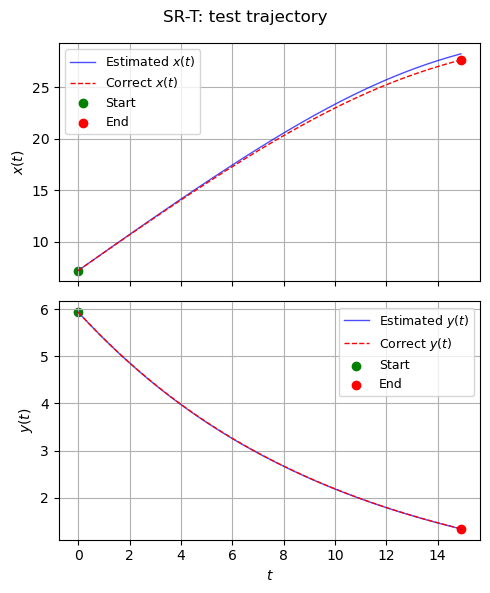

In [7]:
n_test = 10
rmse, _ = evaluate_RMSE(model, ode, freq, n_test, [10., 10., 2.], [0., 0., 1.], dim_k)
print('SR_T Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6., 1.8]
title = 'SR-T: test trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_58236/2836757555.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


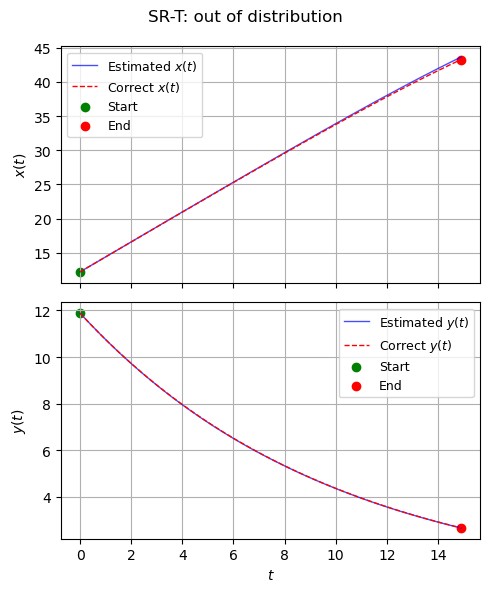

In [8]:
evaluate_sample = 1
ics = [12, 12, 2.2]
title = 'SR-T: out of distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_58236/2836757555.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


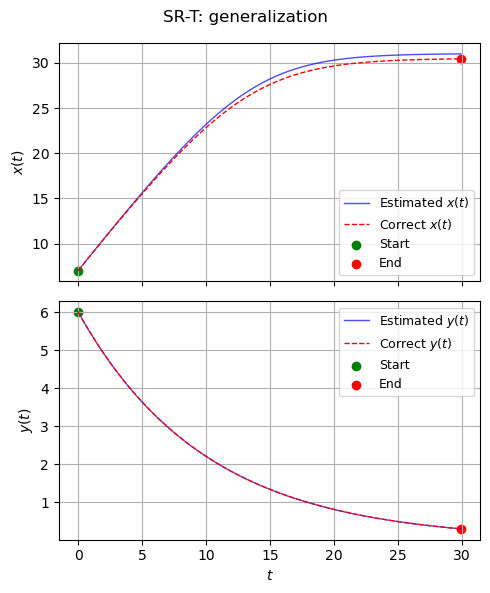

In [9]:
evaluate_sample = 1
ics = [7, 6, 1.8]
title = 'SR-T: generalization'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=30)

In [ ]:
# running D-CODE
building_blocks_lambda0, function_names0 = D_CODE_simulation(ode_name, ode_param, 0, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)
building_blocks_lambda1, function_names1 = D_CODE_simulation(ode_name, ode_param, 1, freq, n_sample, noise_ratio, seed=seed, n_seed=n_seed, T=T)

Running with: ode_name=HillODE_par_k, ode_param=[2.8, 4.0, 0.1], x_id=0, freq=10, n_sample=50, noise_sigma=0.01, seed=100, n_seed=1
Dataset shape:  (301, 50, 3)
Functions set:  {'neg': 1, 'mul': 1, 'pow': 1, 'add': 1, 'div': 1}
 
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0    10.70      5.98276e+28        7          26.6997          47.9432      5.48m
   1     7.45      7.10005e+20        7          24.7518          36.3714      4.82m
   2     4.67      3.66506e+21       13          4.87982          2.35152      4.34m
 
promising programs:
div(X1, div(add(X1, div(X0, mul(div(X0, X2), X1))), X2))
div(X1, div(add(X1, div(X0, mul(div(X0, X2), X1))), X2))
div(X1, div(add(X1, div(X0, mul(div(X0, X2), X1))), X2))
div(pow(X1, 1.234), div(add(X1, 2.188), X2))
div(X1, div(add(X1, div(X0, pow(

In [ ]:
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d
import numpy as np

class SRModel:
    def __init__(self, f):
        self.f = f
    
    def simulate(self, x0, t, u):
        # se u è un array (n_samples, 1)
        u_fun = interp1d(t, u, axis=0, kind="cubic", fill_value="extrapolate")

        def rhs(ti, z):
            k = float(u_fun(ti))   # interpolazione CORRETTA
            return self.f(z, ti, k)

        sol = solve_ivp(rhs, [t[0], t[-1]], x0, t_eval=t, method="LSODA")
        return sol.y.T


    
f = lambda x,t,k: [
    x[1]*k/1/(x[1] + (0.57662815545153069*x[1] + 3.235939085119168)/x[1]**2), 
    -0.099483325637301876 * x[1],
]
model = SRModel(f)

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def evaluate_traj(model, ode, freq, n_sample, init_high, init_low,
                  dim_x=1, dim_k=1, title=None, T_aux=100):

    np.random.seed(666)
    dt = 1 / freq
    time_vector = np.arange(0, T_aux, dt)
    t = np.arange(0, T_aux, dt)
    T_plot = len(t)

    # true trajectories:
    dg_true = data.DataGenerator(ode, T_aux, freq, n_sample,
                                 noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):
        correct_param = xt_true[0, i, -dim_k:]
        t = np.arange(0, T_aux, dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot, 1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t=t[:T_plot], u=test_params)
        else:
            pred_0 = model.simulate(xt_true[0, i, :], t=t[:T_plot])
        pred_0_list.append(pred_0)

    # reshape
    xt_true = xt_true[:len(pred_0), :, :]
    time_vector = time_vector[:len(pred_0)]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2)).squeeze()

    # ------------ PLOTTING ------------
    if n_sample == 1:

        # -------- dim_x = 1 ----------
        if dim_x == 1:
            fig, ax = plt.subplots(1, 1, figsize=(5, 4))
            ax.plot(time_vector, pred_0_list, color='blue', linewidth=1.0,
                    alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(time_vector, xt_true, color='red', linewidth=1.0,
                    linestyle='--', label=r'Correct Trajectory')
            ax.scatter(time_vector[0], xt_true[0], color='green', label=r'Start')
            ax.scatter(time_vector[-1], xt_true[-1], color='red', label=r'End')
            ax.set_xlabel(r'$t$')
            ax.set_ylabel(r'$x$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)

        # -------- dim_x = 2 (RISCRITTO) ----------
        elif dim_x == 2:

            fig, axes = plt.subplots(2, 1, figsize=(5, 6), sharex=True)

            # ----- PLOT x(t) -----
            axes[0].plot(time_vector, pred_0_list[:, 0], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $x(t)$')
            axes[0].plot(time_vector, xt_true[:, 0], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $x(t)$')

            # Start & End sulla traiettoria vera
            axes[0].scatter(time_vector[0], xt_true[0, 0], color='green', label='Start')
            axes[0].scatter(time_vector[-1], xt_true[-1, 0], color='red', label='End')

            axes[0].set_ylabel(r'$x(t)$')
            axes[0].legend(fontsize=9)
            axes[0].grid(True)

            # ----- PLOT y(t) -----
            axes[1].plot(time_vector, pred_0_list[:, 1], color='blue',
                        linewidth=1.0, alpha=0.7, label=r'Estimated $y(t)$')
            axes[1].plot(time_vector, xt_true[:, 1], color='red',
                        linewidth=1.0, linestyle='--', label=r'Correct $y(t)$')

            # Start & End sulla traiettoria vera
            axes[1].scatter(time_vector[0], xt_true[0, 1], color='green', label='Start')
            axes[1].scatter(time_vector[-1], xt_true[-1, 1], color='red', label='End')

            axes[1].set_xlabel(r'$t$')
            axes[1].set_ylabel(r'$y(t)$')
            axes[1].legend(fontsize=9)
            axes[1].grid(True)

            if title:
                fig.suptitle(r'%s' % title)

            fig.tight_layout()


        # -------- dim_x = 3 ----------
        else:
            fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': '3d'})
            ax.plot(pred_0_list[:, 0], pred_0_list[:, 1], pred_0_list[:, 2],
                    color='blue', linewidth=1.0, alpha=0.7, label=r'Estimated Trajectory')
            ax.plot(xt_true[:, 0], xt_true[:, 1], xt_true[:, 2],
                    color='red', linewidth=1.0, linestyle='--', label=r'Correct Trajectory')
            ax.scatter(xt_true[:, 0][0], xt_true[:, 1][0], xt_true[:, 2][0], color='green', label=r'Start')
            ax.scatter(xt_true[:, 0][-1], xt_true[:, 1][-1], xt_true[:, 2][-1], color='red', label=r'End')
            ax.set_xlabel(r'$x$')
            ax.set_ylabel(r'$y$')
            ax.set_zlabel(r'$z$')
            if title:
                ax.set_title(r'%s' % title)
            ax.legend(fontsize=9, loc='lower right')
            ax.grid(True)


from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_squared_error

def evaluate_RMSE(model, ode, freq, n_sample, init_high, init_low, dim_k=1):
    # function computing the RMSE (and the MSE) of a given model: 

    np.random.seed(666)
    dt = 1 / freq
    TIME = min(ode.T, 100) 

    # true trajectories:
    dg_true = data.DataGenerator(ode, TIME, freq, n_sample, noise_sigma=0., init_high=init_high, init_low=init_low)
    xt_true = dg_true.xt
    #print(np.shape(xt_true))

    # estimated trajectories:
    pred_0_list = []
    for i in range(n_sample):

        correct_param = xt_true[0, i, -dim_k:]
        #print(np.shape(correct_param))

        t = np.arange(0,TIME,dt)
        T_plot = len(t)
        test_params = np.tile(correct_param, (T_plot,1))
        if dim_k != 0:
            pred_0 = model.simulate(xt_true[0, i, :][:-dim_k], t= t[:T_plot], u = test_params)
        else: # dim_k == 0
            pred_0 = model.simulate(xt_true[0, i, :], t= t[:T_plot])
        pred_0_list.append(pred_0)
    #print(np.shape(pred_0_list))


    xt_true = xt_true[:len(pred_0), :, :]
    if dim_k != 0:
        xt_true = xt_true[:, :, :-dim_k]
    xt_true = xt_true.squeeze()
    #print(np.shape(xt_true)) #(151, 25, 2)
    pred_0_list = np.transpose(pred_0_list, (1, 0, 2))
    pred_0_list = pred_0_list.squeeze()
    #print(np.shape(pred_0_list)) #(151, 25, 2)

    # RMSE:
    rmse_0_list = []
    mse_0_list = []
    for i in range(n_sample):
        rmse_0 = root_mean_squared_error(xt_true[:, i], pred_0_list[:,i]) 
        mse_0 = mean_squared_error(xt_true[:, i], pred_0_list[:,i])
        rmse_0_list.append(rmse_0)
        mse_0_list.append(mse_0)
    rmse_0 = np.mean(rmse_0_list)
    mse_0 = np.mean(mse_0_list)
    return rmse_0, mse_0

/tmp/ipykernel_58236/2198305416.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA
/tmp/ipykernel_58236/2198305416.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


D-CODE Model RMSE:  0.03681686698538419


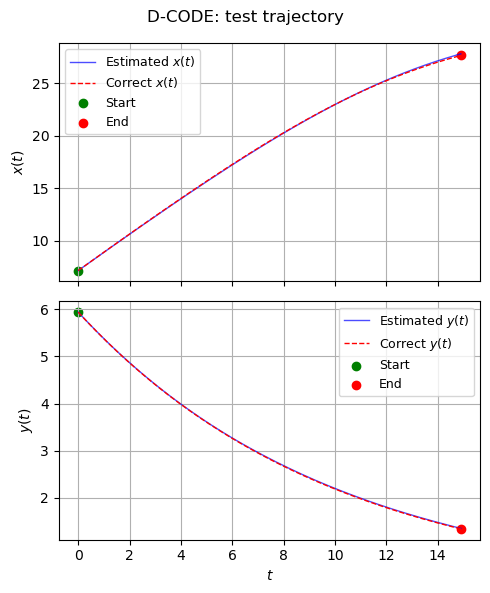

In [12]:
n_test = 10
rmse, _ = evaluate_RMSE(model, ode, freq, n_test, [10., 10., 2.], [0., 0., 1.], dim_k)
print('D-CODE Model RMSE: ', rmse)

evaluate_sample = 1
ics = [7., 6., 1.8]
title = 'D-CODE: test trajectory'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_58236/2198305416.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


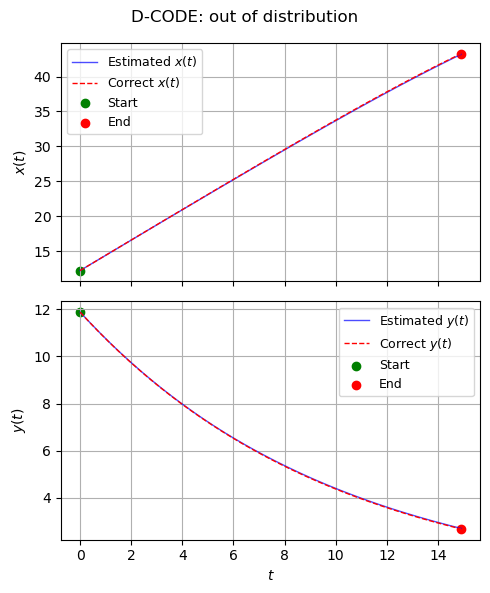

In [13]:
evaluate_sample = 1
ics = [12, 12, 2.2]
title = 'D-CODE: out of distribution'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=15)

/tmp/ipykernel_58236/2198305416.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  k = float(u_fun(ti))   # interpolazione CORRETTA


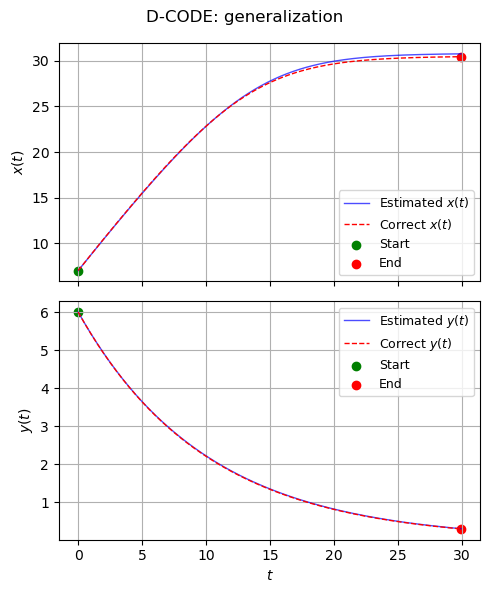

In [14]:
evaluate_sample = 1
ics = [7, 6, 1.8]
title = 'D-CODE: generalization'
evaluate_traj(model, ode, freq, evaluate_sample, ics, ics, dim_x, dim_k, title=title, T_aux=30)